In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from dense_image_aligment import show_data, image_aligment_method, read_as_grayscale
from dense_image_aligment import save_aligment_progress, read_as_colored, show_data
from dense_image_aligment.transformations import AffineTransformation

import cv2

In [2]:
def create_simple_gauss(mu, sigma, shape):
    x = np.linspace(0, 1, shape[0])
    y = np.linspace(0, 1, shape[1])
    
    xx, yy = np.meshgrid(x, y, indexing='xy')
    
    z = np.exp(-( (xx - mu[0])**2 / (sigma[0]**2) +  (yy - mu[1])**2 / (sigma[1]**2)) / 2) / (np.sqrt(sigma[0]**2 + sigma[1]**2) * np.sqrt(2 * np.pi))
    return z


def create_simple_L(shape):
    mask = np.zeros(shape, dtype=np.float32)
    mask[shape[0] // 5 : shape[0] * 4 // 5, shape[1] // 5 : shape[0] * 2 // 5] = 1.
    mask[shape[0] // 2 : shape[0] * 4 // 5, shape[1] // 5 : shape[0] * 4 // 5] = 1.
    
    return mask 

In [3]:
# template = create_simple_gauss([0.5, 0.5], [0.1, 0.1], [100, 100])
# image = create_simple_gauss([0.5, 0.5], [0.1, 0.1], [100, 100])
template = create_simple_L([100, 90])
image = create_simple_L([100, 90])

In [4]:
method, params = image_aligment_method(key='forward_additive')
params['alpha'] = 1.0
params['max_iterations'] = 500
params['convergence_threshold'] = 0.000001
params['p_init'] = np.array(
    [
        [1, 0.1, 0.], 
        [0.5, 1., -10.],
    ]
).reshape(-1)

transform = AffineTransformation(params['p_init'])

In [5]:
params['p_init']

array([  1. ,   0.1,   0. ,   0.5,   1. , -10. ])

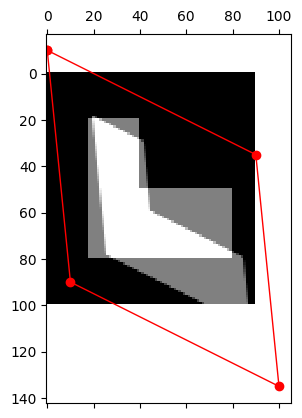

In [6]:
show_data(
    image=image, 
    template=template, 
    coords_transform=transform
)

In [7]:
ps = method(
    image=image,
    template=template,
    coord_transform=transform,
    **params
)

iteration: 19, |∇p|=0.00000:   4%|▍         | 19/500 [00:01<00:32, 14.71it/s]

Converged


In [8]:
ps[-1].round(2)

array([ 1.,  0., -0.,  0.,  1., -0.])

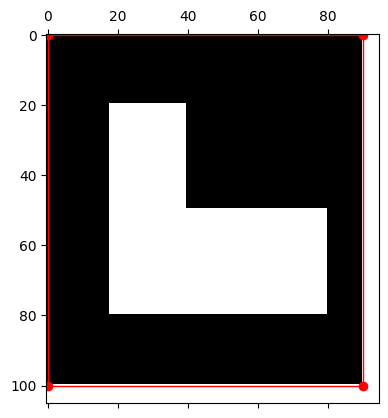

In [9]:
transform.p = ps[-1]

show_data(
    image=image, 
    template=template, 
    coords_transform=transform
)

100%|██████████| 21/21 [00:02<00:00,  9.20it/s]


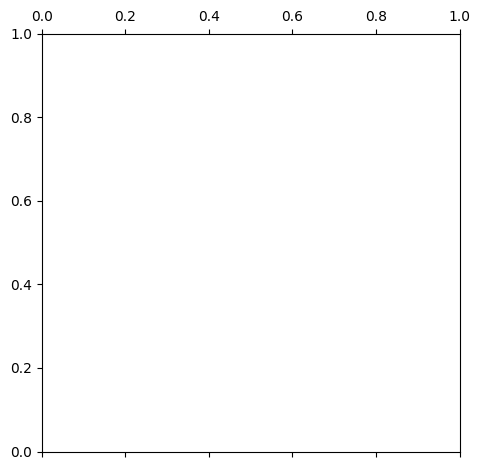

In [10]:
save_aligment_progress(
    f'../docs/images/affine_alignment_example.gif',
    image=image,
    template=template,
    coords_transform=transform,
    ps=ps,
    duration=200,
)

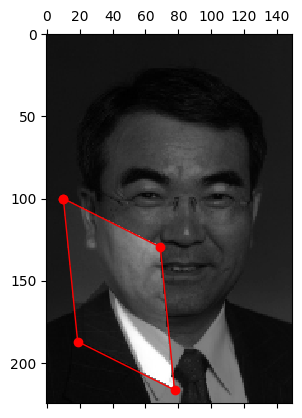

In [13]:
image = read_as_grayscale('../media/kanade_image_1.jpg')
template = read_as_grayscale('../media/kanade.jpg')


method, params = image_aligment_method(key='forward_additive')
params['alpha'] = 1.0
params['max_iterations'] = 1000
params['convergence_threshold'] = 1e-8
params['p_init'] = np.array(
    [
        [1, 0.1, 10], 
        [0.5, 1., 100.],
    ]
).reshape(-1)

affine_transform = AffineTransformation(params['p_init'].reshape(-1))

show_data(
    image=image, 
    template=template, 
    coords_transform=affine_transform
)

In [14]:
params['p_init'] = cv2.invertAffineTransform(params['p_init'].reshape(2, 3)).reshape(-1)
ps = method(
    image=template,
    template=image,
    coord_transform=affine_transform,
    **params
)

iteration: 72, |∇p|=0.00000:   7%|▋         | 72/1000 [00:17<03:43,  4.15it/s]

Converged


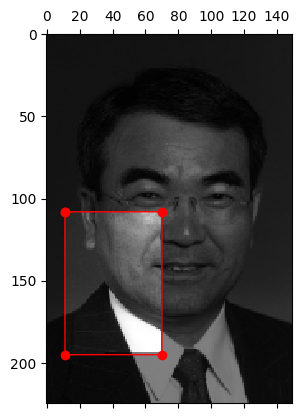

In [15]:
affine_transform.p = cv2.invertAffineTransform(ps[-1].reshape(2, 3)).reshape(-1)

show_data(
    image=image, 
    template=template, 
    coords_transform=affine_transform
)

100%|██████████| 74/74 [00:06<00:00, 11.00it/s]


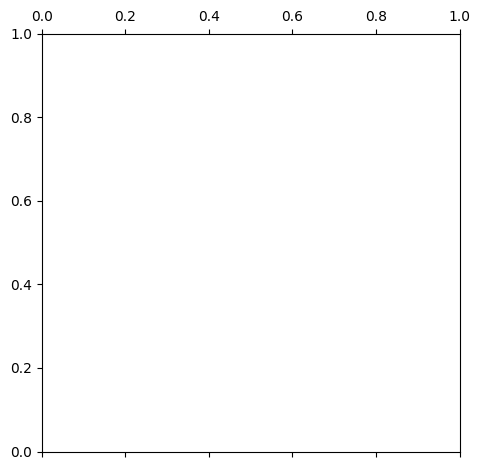

In [22]:
ps_ = [cv2.invertAffineTransform(p.reshape(2, 3)).reshape(-1) for p in ps]

save_aligment_progress(
    f'../docs/images/affine_alignment_example.gif',
    image=image,
    template=template,
    coords_transform=affine_transform,
    ps=ps_,
    duration=300,
)